# Appendix A3: Soil and Metereological Data EDA

In [1]:
import datetime as dt
from pathlib import Path
import math
import os
import sqlite3
import json
import geopandas as gpd
import pygeos
import pyproj    
import shapely
import shapely.ops as ops
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import Polygon
from functools import partial

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import train_test_split


from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from functools import partial


from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

## Data Collection: Soil and Metereological 

#### USA Shape File https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

In [2]:
USA = gpd.read_file("Data/County/cb_2018_us_county_500k.shp")
USA.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.64540, -84.12483 37.646..."
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."


#### 3a. Load the dataset 3: US Drought Data - https://power.larc.nasa.gov/

In [5]:
drought_soil = pd.read_csv('Data/Drought_Soil.csv')

#### 3b. Daily weather summary data https://www.noaa.gov/

In [3]:
# import necessary libraries
import glob
  
# use glob to get all the csv files 
# in the folder
current_dir = Path(os.getcwd()).absolute()
data_dir = current_dir.joinpath('Data')
weather_dir = data_dir.joinpath('weather')
csv_files = glob.glob(os.path.join(weather_dir, "*.csv"))


# loop over the list of csv files
df_list = []
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f)
    df_list.append(df)

In [4]:
ca_daily_df = []
for i in df_list:
    df = pd.DataFrame(i)
    df = df.dropna()
    ca_daily_df.append(df)
ca_daily_df = pd.concat(ca_daily_df)

### Data Preliminary Analysis

In [6]:
# check for missing value
def percentMissing(df):
    
    df_numeric = df.select_dtypes(include=[np.number])
    numeric_cols = df_numeric.columns.values
    
    # % of missing data
    for col in df.columns:
        # create missing indicator for features with missing data
        missing = df[col].isnull()
        pct_missing = np.mean(missing)*100
        #if pct_missing >60:
        print('{} - {}%'.format(col, round(pct_missing)))
        num_missing = np.sum(missing)

In [7]:
# Checking data type
def Datatype(df):
    # shape and data types of the data
    print("There are {} rows and {} columns".format(df.shape[0], df.shape[1]))
    print(df.dtypes)

    # select numeric columns
    df_numeric = df.select_dtypes(include=[np.number])
    numeric_cols = df_numeric.columns.values
    print(numeric_cols)

    # select non numeric columns
    df_non_numeric = df.select_dtypes(exclude=[np.number])
    non_numeric_cols = df_non_numeric.columns.values
    print(non_numeric_cols)

## Data Exploration

In [8]:
drought_soil.head(4)
drought_soil = drought_soil.drop(['Unnamed: 0', 'score'], axis = 1)

In [9]:
drought_soil['DroughtYear'].describe()

count    277628.000000
mean       2015.500411
std           2.872668
min        2011.000000
25%        2013.000000
50%        2016.000000
75%        2018.000000
max        2020.000000
Name: DroughtYear, dtype: float64

In [14]:
y = drought_soil[drought_soil['lon'] <=-119.5]
z = drought_soil[(drought_soil['lat'] <= 39.5) & (drought_soil['lat'] >= 36.5)]
w = z[(z['lon'] >=-119.5) & (z['lon'] <=-116)]
v = drought_soil[drought_soil['lat'] <= 36.5]
crs = {'init': "EPSG:4326"}
plot_df0 = pd.concat([y,z,w,v])
plot_df0 = plot_df0[~((plot_df0['lat']>39) & (plot_df0['lon']>-120))]
plot_df0 = plot_df0[~((plot_df0['lat']>37.6) & (plot_df0['lon']>-118.5))]

geometry = [Point(xy) for xy in zip(plot_df0['lon'], plot_df0['lat'])]
geometry[:3]
geo_soil_df = gpd.GeoDataFrame(plot_df0, crs=crs, geometry=geometry)

In [15]:
soil_df = geo_soil_df[['fips','lat','lon','elevation', 'slope1','slope2','slope3',
                       'slope4','slope6','slope8','aspectN','aspectE', 'aspectS', 
                       'aspectW','WAT_LAND','NVG_LAND','URB_LAND','GRS_LAND', 'FOR_LAND', 
                       'CULTRF_LAND','CULTIR_LAND','SQ2','SQ3', 'SQ4', 'geometry']]
soil_df.shape

(361647, 25)

In [16]:
soil_df = soil_df[~soil_df.duplicated(['fips'], keep='first')]
soil_df.shape

(61, 25)

In [17]:
soil_df[['lat','lon','elevation', 'slope1','slope2','slope3','slope4','slope6','slope8']].describe()

,lat,lon,elevation,slope1,slope2,slope3,slope4,slope6,slope8
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,37.761497,-120.526784,643.426230,0.041205,0.187852,0.117167,0.118982,0.243261,0.049569
std,2.183253,2.200278,678.960148,0.076777,0.267800,0.112690,0.102348,0.183273,0.090065
min,33.023604,-123.980998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.561977,-122.007205,106.000000,0.000400,0.005300,0.029800,0.044400,0.028400,0.000000
50%,38.021451,-120.773446,444.000000,0.001600,0.023200,0.082700,0.096400,0.275800,0.013000
75%,39.177739,-119.749852,825.000000,0.044500,0.322700,0.175900,0.184900,0.402200,0.056300
max,41.749903,-114.038793,2630.000000,0.343100,0.745400,0.561200,0.483300,0.556000,0.481400


In [18]:
soil_df[['aspectN','aspectE', 'aspectS', 'aspectW']].describe()

,aspectN,aspectE,aspectS,aspectW
count,61.000000,61.000000,61.000000,61.000000
mean,0.151067,0.165772,0.192116,0.230715
std,0.093424,0.096897,0.117666,0.137050
min,0.000000,0.000000,0.000000,0.000000
25%,0.064200,0.089500,0.070300,0.128400
50%,0.163600,0.173000,0.201800,0.238000
75%,0.240400,0.226800,0.289000,0.317900
max,0.348700,0.397800,0.473800,0.560200


In [19]:
soil_df[['WAT_LAND','NVG_LAND','URB_LAND','GRS_LAND', 'FOR_LAND', 'CULTRF_LAND','CULTIR_LAND']].describe()

,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,1.033192,7.304989,2.745081,18.985231,47.190747,1.722027,16.100701
std,5.806408,19.514630,13.599561,14.832669,31.989077,2.404207,28.713621
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,8.869439,18.155117,0.000000,0.000000
50%,0.000000,0.000000,0.055821,15.587294,49.677391,0.272293,0.438461
75%,0.000000,2.083883,0.429140,29.065670,77.980881,3.188647,15.725230
max,44.035000,78.871132,99.955193,58.796833,90.971321,9.187908,99.956841


In [20]:
soil_df[['SQ2','SQ3', 'SQ4']].describe() #### these are discrete variables

,SQ2,SQ3,SQ4
count,61.000000,61.000000,61.000000
mean,1.360656,1.573770,1.163934
std,1.155174,1.257763,1.113258
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000
75%,1.000000,2.000000,1.000000
max,7.000000,7.000000,7.000000


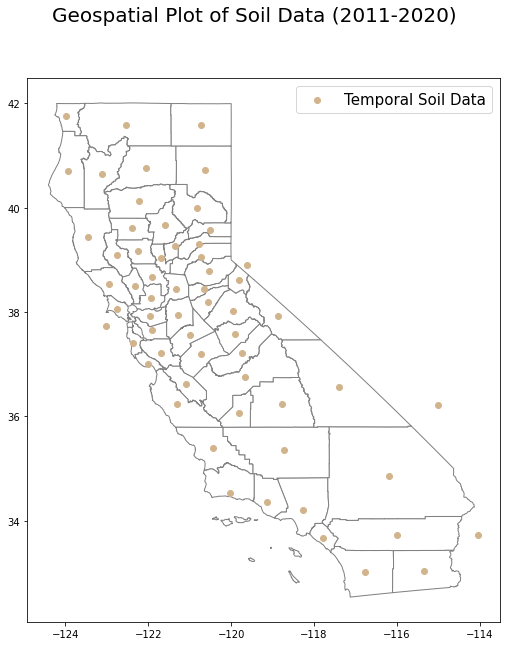

In [21]:
fig, ax = plt.subplots(figsize = (10, 10))
fig.suptitle('Geospatial Plot of Soil Data (2011-2020)', fontsize=20)

USA[USA['STATEFP'] == '06'].plot(ax=ax, edgecolor="grey", facecolor="white")
soil_df.plot(ax=ax, color="tan", label="Temporal Soil Data")
plt.legend(prop={'size':15})

In [22]:
# Histograms
def histogram(xaxes, df, x, y, nrows, color):
    plt.rcParams['figure.figsize'] = (x, y)
        
    fig, axes = plt.subplots(nrows = nrows, ncols = 2)
    fig.suptitle('Distribution of Meteorological Indicators in West Coast Region (2011-2020)', fontsize=30)

    # draw histograms in for loop
    axes = axes.ravel()
    for idx, ax in enumerate(axes):
        # drops NaN values
        ax.hist(df[num_features[idx]].dropna(), bins=40, color= color)
        ax.set_xlabel(xaxes[idx], fontsize=15)
        ax.set_ylabel('Counts', fontsize=15)
        ax.tick_params(axis='both', labelsize=15)
        right_side = ax.spines["right"]
        right_side.set_visible(False)
        top = ax.spines["top"]
        top.set_visible(False)

    plt.show()

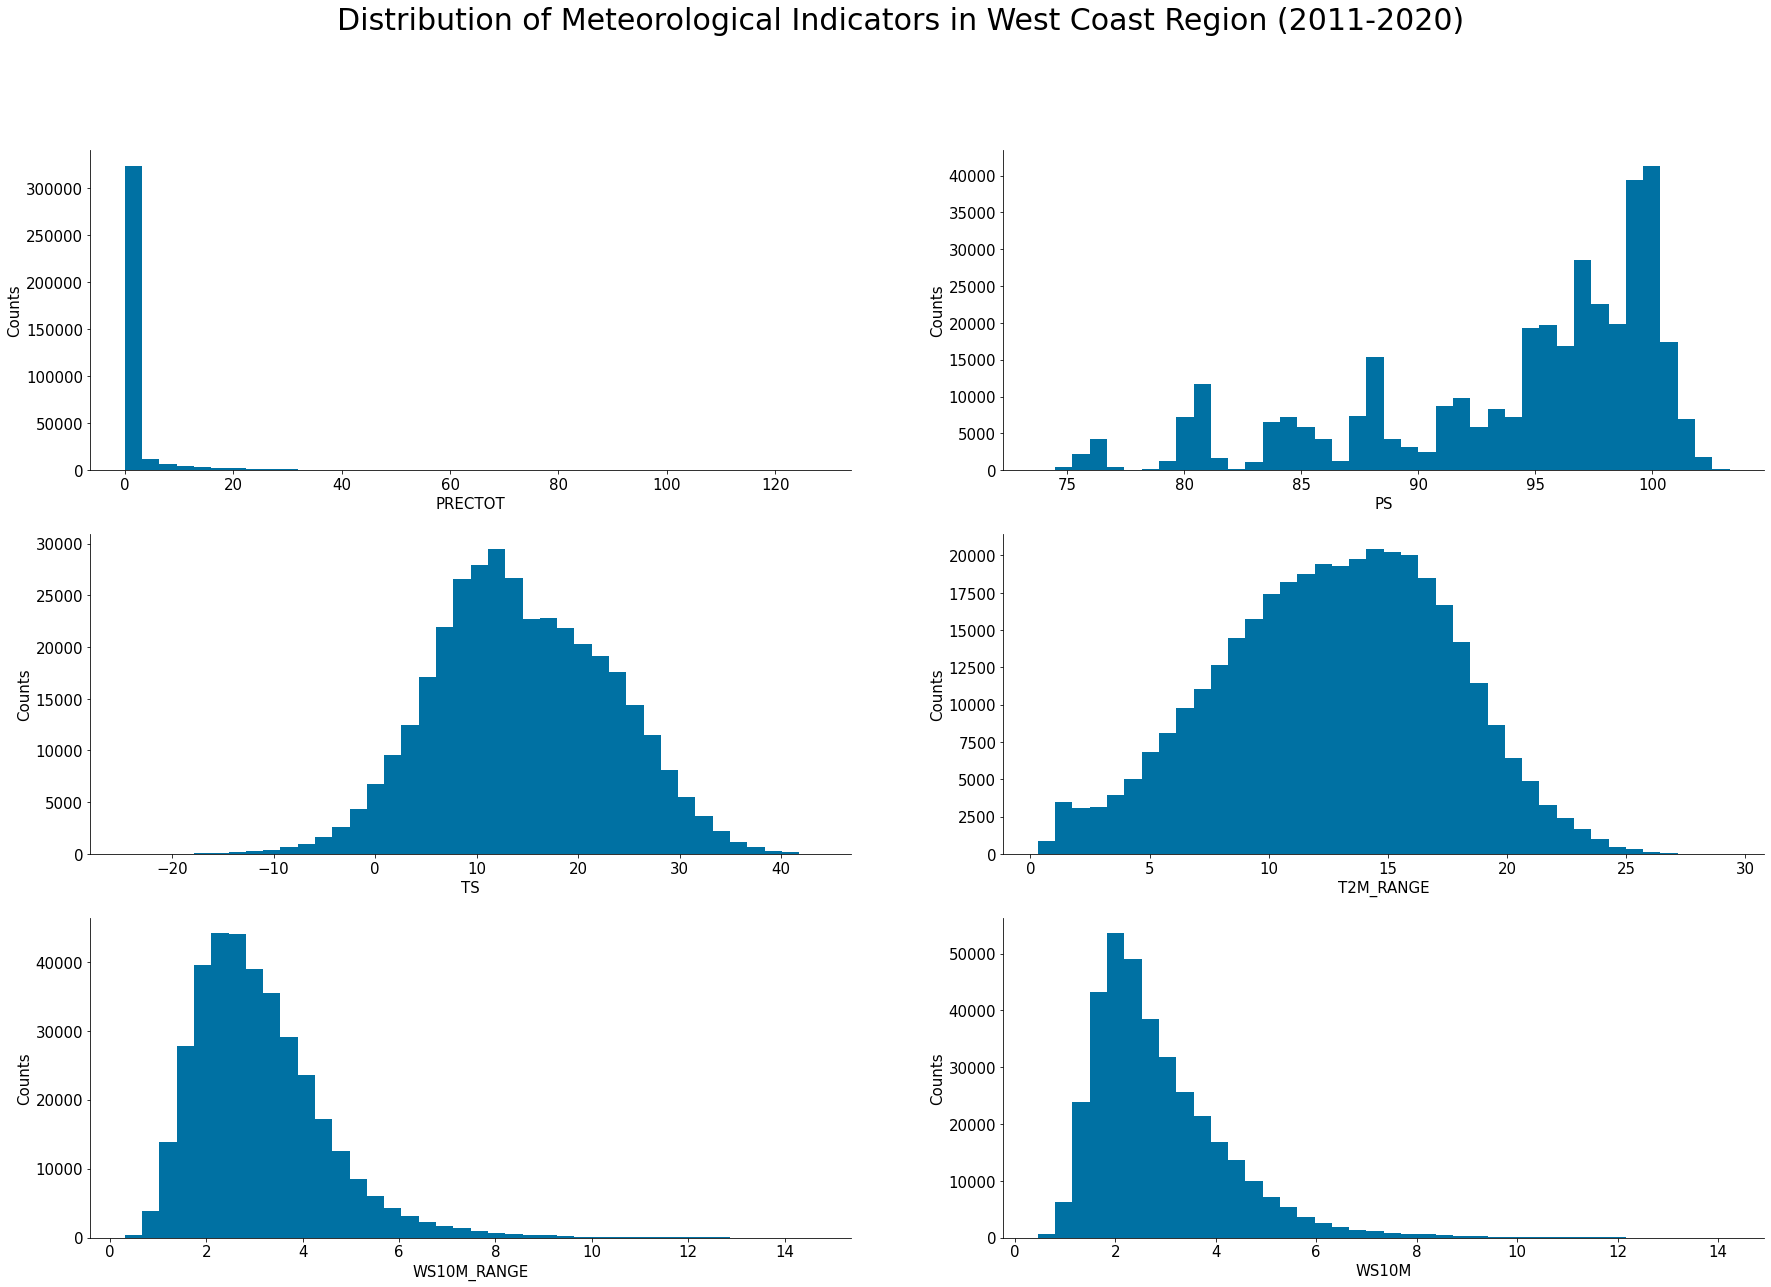

In [23]:
# Specify the features of interest
num_features = ['PRECTOT', 'PS','TS', 'T2M_RANGE', 'WS10M_RANGE', 'WS10M']
xaxes = num_features
histogram(xaxes, geo_soil_df, 30,20, 3, "#0071A3")

In [24]:
grouped = geo_soil_df.groupby(by=['DroughtMonth'] ,as_index=False).agg({'PRECTOT': "mean", 
                                                                        'PS':"mean", 
                                                                        'TS':"mean", 
                                                                        'T2M_RANGE':"mean", 
                                                                        'WS10M_RANGE': "mean", 
                                                                        'WS10M': "mean"})
df = grouped[["PRECTOT",'PS', 'TS', 'T2M_RANGE','WS10M_RANGE', 'WS10M']]
Month_column = grouped[['DroughtMonth']]

In [25]:
sc = StandardScaler()
df_std = sc.fit_transform(df)
df_std = pd.DataFrame(df_std, columns=["PRECTOT",'PS', 'TS', 'T2M_RANGE','WS10M_RANGE', 'WS10M'])
df_std['DroughtMonth'] = Month_column['DroughtMonth']

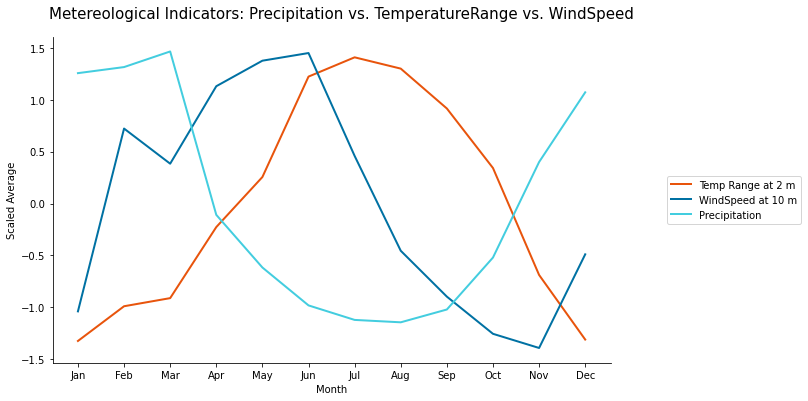

In [26]:
df_std = df_std.replace({'DroughtMonth' : {1: 'Jan', 2 : 'Feb', 3 : 'Mar', 4: 'Apr', 
                                           5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
                                           9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}})
fig, ax = plt.subplots(figsize = (10,6))
fig.suptitle('Metereological Indicators: Precipitation vs. TemperatureRange vs. WindSpeed', 
             x=0.12, y=.95, horizontalalignment='left', verticalalignment='top', fontsize=15)
plot3 = sns.lineplot(data=df_std, x="DroughtMonth", y='T2M_RANGE', color="#E8540C", linewidth=2, 
                     ax=ax, label="Temp Range at 2 m")
plot4 = sns.lineplot(data=df_std, x="DroughtMonth", y='WS10M', color="#0071A3", linewidth=2, 
                     ax=ax, label="WindSpeed at 10 m")
plot6 = sns.lineplot(data=df_std, x="DroughtMonth", y="PRECTOT", color="#43CDDF", linewidth=2, 
                     ax=ax, label="Precipitation")

ax.set_xticks([0,1,2,3,4,5,6,7, 8,9, 10,11])
ax.set_xlabel("Month")
ax.set_ylabel("Scaled Average")

plt.legend(loc="right", bbox_to_anchor=(1.35, 0.5))
sns.despine()
plt.show() 

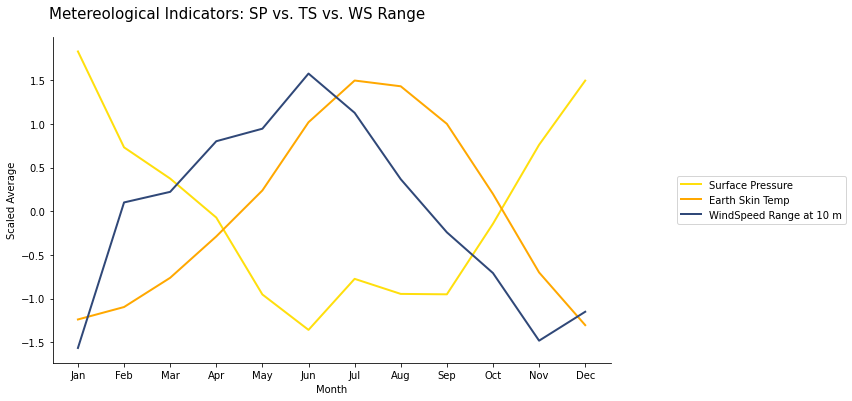

In [27]:
df_std = df_std.replace({'DroughtMonth' : {1: 'Jan', 2 : 'Feb', 3 : 'Mar', 4: 'Apr', 
                                           5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
                                           9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}})
fig, ax = plt.subplots(figsize = (10,6))
fig.suptitle('Metereological Indicators: SP vs. TS vs. WS Range', 
             x=0.12, y=.95, horizontalalignment='left', verticalalignment='top', fontsize=15)
plot1 = sns.lineplot(data=df_std, x="DroughtMonth", y='PS', color="#FFDF0D", linewidth=2, 
                     ax=ax, label="Surface Pressure")
plot2 = sns.lineplot(data=df_std, x="DroughtMonth", y='TS', color="#FFA800", linewidth=2, 
                     ax=ax, label="Earth Skin Temp")
plot5 = sns.lineplot(data=df_std, x="DroughtMonth", y='WS10M_RANGE', color="#304878", linewidth=2, 
                     ax=ax, label="WindSpeed Range at 10 m")

ax.set_xticks([0,1,2,3,4,5,6,7, 8,9, 10,11])
ax.set_xlabel("Month")
ax.set_ylabel("Scaled Average")
plt.legend(loc="right", bbox_to_anchor=(1.43, 0.5))
sns.despine()
plt.show() 

### 1d. Data Preliminary Analysis: Daily Summaries (2010 -2020)

In [28]:
ca_daily_df['DATE'] = pd.to_datetime(ca_daily_df['DATE'])
ca_daily_df['TempYear'] = ca_daily_df['DATE'].dt.year
ca_daily_df['TempMonth'] = ca_daily_df['DATE'].dt.month
ca_daily_df['TempDay'] = ca_daily_df['DATE'].dt.day

In [29]:
ca_daily_df = ca_daily_df.rename(columns={'STATION': 'StationCode', 'NAME': 'StationName', 
                                          'LATITUDE': 'StationLatitude', 'LONGITUDE': 'StationLongitude', 
                                          'ELEVATION': 'Elevation', 'DATE':'TempDate', 'PRCP':'Precip',
                                          'TMAX': 'Max_Temp', 'TMIN': 'Min_Temp'})

In [30]:
ca_daily_df['Avg_Temp'] = (ca_daily_df['Min_Temp'] + ca_daily_df['Max_Temp'])/2
ca_daily_df.shape

(1314180, 13)

In [31]:
percentMissing(ca_daily_df)

StationCode - 0%
StationName - 0%
StationLatitude - 3%
StationLongitude - 3%
Elevation - 3%
TempDate - 0%
Precip - 0%
Max_Temp - 0%
Min_Temp - 0%
TempYear - 0%
TempMonth - 0%
TempDay - 0%
Avg_Temp - 0%


#### Deleting duplicates

In [32]:
ca_daily_df.shape

(1314180, 13)

In [33]:
ca_daily_df = ca_daily_df.sort_values(["Max_Temp", "Min_Temp"], ascending=False)

In [34]:
# check for duplicates in coordinates
ca_daily_df = ca_daily_df[~ca_daily_df.duplicated(['StationLatitude', 'StationLongitude', 'TempDate'], keep = 'first')]
ca_daily_df.shape

(1269731, 13)

In [35]:
grouped1 = ca_daily_df.groupby(by=['TempMonth'] ,as_index=False).agg({'Precip': "mean", 'Avg_Temp': "mean"})
df1 = grouped1[["Precip", "Avg_Temp"]]
Month_column1 = grouped1[['TempMonth']]

In [36]:
sc = StandardScaler()
df_std1 = sc.fit_transform(df1)
df_std1 = pd.DataFrame(df_std1, columns=["Precip", "Avg_Temp"])
df_std1['TempMonth'] = Month_column1['TempMonth']

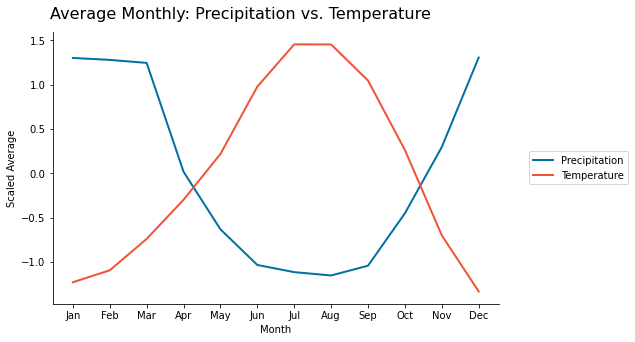

In [37]:
df_std1 = df_std1.replace({'TempMonth' : {1: 'Jan', 2 : 'Feb', 3 : 'Mar', 4: 'Apr', 
                                        5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
                                        9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}})
fig, ax = plt.subplots(figsize = (8,5))
fig.suptitle('Average Monthly: Precipitation vs. Temperature', 
             x=0.12, y=.95, horizontalalignment='left', verticalalignment='top', fontsize=16)
plot1 = sns.lineplot(data=df_std1, x="TempMonth", y='Precip', color="#0071A3", linewidth=2, 
                     ax=ax, label="Precipitation")
plot2 = sns.lineplot(data=df_std1, x="TempMonth", y='Avg_Temp', color="#F05437", linewidth=2, 
                     ax=ax, label="Temperature")

ax.set_xticks([0,1,2,3,4,5,6,7, 8,9, 10,11])
ax.set_xlabel("Month")
ax.set_ylabel("Scaled Average")
plt.legend(loc="right", bbox_to_anchor=(1.3, 0.5))
sns.despine()
plt.show() 

In [38]:
geometry = [Point(xy) for xy in zip(ca_daily_df['StationLongitude'], ca_daily_df['StationLatitude'])]
geometry[:3]
geo_daily_df = gpd.GeoDataFrame(ca_daily_df, crs=crs, geometry=geometry)
geo_daily_df.head(2)

,StationCode,StationName,StationLatitude,StationLongitude,Elevation,TempDate,Precip,Max_Temp,Min_Temp,TempYear,TempMonth,TempDay,Avg_Temp,geometry
99763,USC00042319,"DEATH VALLEY NATIONAL PARK, CA US",36.46263,-116.86720,-59.1,2020-08-16,0.0,130.0,96.0,2020,8,16,113.0,POINT (-116.86720 36.46263)
96964,USW00093115,"IMPERIAL BEACH REAM FIELD NAS, CA US",32.56797,-117.11715,7.2,2010-12-08,0.0,130.0,1.0,2010,12,8,65.5,POINT (-117.11715 32.56797)


In [39]:
geo_daily_df = geo_daily_df.to_crs({'init': "EPSG:3310"})

In [40]:
geo_daily_df['Precip'].describe()

count    1.269731e+06
mean     6.134752e-02
std      2.677502e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.218000e+01
Name: Precip, dtype: float64

#### Plotting Average Monthly Fires with Metereological Indicators

In [41]:
grouped2 = geo_fires_df['FireMonth'].value_counts().to_frame()
grouped2 = grouped2.sort_index()
grouped2.reset_index(level=0, inplace=True)
grouped2['AvgFires'] = grouped2['FireMonth'].apply(lambda x: x/10)
grouped2['FireMonth'] = grouped2['index']
grouped2 = grouped2.iloc[: , 1:]

NameError: name 'geo_fires_df' is not defined

In [ ]:
df2 = grouped2[["AvgFires"]]
Month_column2 = grouped2[['FireMonth']]

In [ ]:
sc = StandardScaler()
df_std2 = sc.fit_transform(df2)
df_std2 = pd.DataFrame(df_std2, columns=["AvgFires"])
df_std2['FireMonth'] = Month_column2['FireMonth']

In [ ]:
df_std1 = df_std1.replace({'TempMonth' : {1: 'Jan', 2 : 'Feb', 3 : 'Mar', 4: 'Apr', 
                                        5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
                                        9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}})
df_std2 = df_std2.replace({'FireMonth' : {1: 'Jan', 2 : 'Feb', 3 : 'Mar', 4: 'Apr', 
                                        5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
                                        9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}})
fig, ax = plt.subplots(figsize = (8, 5))
fig.suptitle('Average Monthly: Precipitation vs. Fires', fontsize=16)
plot1 = sns.lineplot(data=df_std1, x="TempMonth", y='Precip', color="#0071A3", linewidth=2, 
                     ax=ax, label="Precipitation")
plot4 = sns.lineplot(data=df_std2, x="FireMonth", y='AvgFires', color="#FFA800", linewidth=2, 
                     ax=ax, label="Fires")
ax.set_xticks([0,1,2,3,4,5,6,7, 8,9, 10,11])
ax.set_xlabel("Month")
ax.set_ylabel("Scaled Average")
plt.legend(loc="upper right")
sns.despine()
plt.show() 

In [ ]:
df_std1 = df_std1.replace({'TempMonth' : {1: 'Jan', 2 : 'Feb', 3 : 'Mar', 4: 'Apr', 
                                        5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
                                        9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}})
df_std2 = df_std2.replace({'FireMonth' : {1: 'Jan', 2 : 'Feb', 3 : 'Mar', 4: 'Apr', 
                                        5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
                                        9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}})
fig, ax = plt.subplots(figsize = (8,5))
fig.suptitle('Average Monthly: Temperatures vs. Fires', fontsize=16)
plot2 = sns.lineplot(data=df_std1, x="TempMonth", y='Avg_Temp', color="#F05437", linewidth=2, 
                     ax=ax, label="Temperature")
plot4 = sns.lineplot(data=df_std2, x="FireMonth", y='AvgFires', color="#FFA800", linewidth=2, 
                     ax=ax, label="Fires")
ax.set_xticks([0,1,2,3,4,5,6,7, 8,9, 10,11])
ax.set_xlabel("Month")
ax.set_ylabel("Scaled Average")
plt.legend(loc="upper right")
sns.despine()
plt.show() 

In [ ]:
df_std2 = df_std2.replace({'FireMonth' : {1: 'Jan', 2 : 'Feb', 3 : 'Mar', 4: 'Apr', 
                                        5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
                                        9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}})
fig, ax = plt.subplots(figsize = (8, 5))
fig.suptitle('Average Monthly: WindSpeed vs. Fires', fontsize=16)
plot3 = sns.lineplot(data=df_std, x="DroughtMonth", y='WS10M', color="#304878", linewidth=2, 
                     ax=ax, label="WindSpeed")
plot4 = sns.lineplot(data=df_std2, x="FireMonth", y='AvgFires', color="#FFA800", linewidth=2, 
                     ax=ax, label="Fires")
ax.set_xticks([0,1,2,3,4,5,6,7, 8,9, 10,11])
ax.set_xlabel("Month")
ax.set_ylabel("Scaled Average")
plt.legend(loc="upper right")
sns.despine()
plt.show() 

In [ ]:
r_df = df_std1[['Precip', 'Avg_Temp']]
r_df['WS'] = df_std['WS10M']
r_df['Avg_Fires'] = df_std2["AvgFires"]

In [ ]:
corrmat = r_df.corr()
top = corrmat.index
plt.figure(figsize=(8,8))

                      #plot heat map
g=sns.heatmap(r_df[top].corr(),annot=True,cmap="Reds")